# Stock Price Prediction


This Python code is an example of time series data analysis and stock price prediction using LSTM (Long Short-Term Memory) neural networks. It covers data preprocessing, model building, and visualization for a dataset containing historical stock price data for Microsoft (MSFT).

This documentation provides an overview of time series data analysis and LSTM-based stock price prediction. 

# Data Loading and Preprocessing

The code starts by loading a CSV file containing historical stock price data for Microsoft.

In [19]:
import pandas as pd
df = pd.read_csv('MSFT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060396,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062553,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063632,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062014,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060936,47894400
...,...,...,...,...,...,...,...
9465,2023-10-03,320.829987,321.390015,311.209991,313.390015,313.390015,21033500
9466,2023-10-04,314.029999,320.040009,314.000000,318.959991,318.959991,20720100
9467,2023-10-05,319.089996,319.980011,314.899994,319.359985,319.359985,16965600
9468,2023-10-06,316.549988,329.190002,316.299988,327.260010,327.260010,25645500


The dataset is trimmed to include only the 'Date' and 'Close' columns.

In [20]:
df = df[['Date', 'Close']]

df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9465,2023-10-03,313.390015
9466,2023-10-04,318.959991
9467,2023-10-05,319.359985
9468,2023-10-06,327.260010


In [21]:
df['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9465    2023-10-03
9466    2023-10-04
9467    2023-10-05
9468    2023-10-06
9469    2023-10-09
Name: Date, Length: 9470, dtype: object

The 'Date' column is converted from a string to a datetime object for time series analysis.

In [23]:
import datetime

def str_to_datetime(s):  #Function to convert a string to a datetime object
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)
datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [24]:
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9465,2023-10-03,313.390015
9466,2023-10-04,318.959991
9467,2023-10-05,319.359985
9468,2023-10-06,327.260010


In [25]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9465   2023-10-03
9466   2023-10-04
9467   2023-10-05
9468   2023-10-06
9469   2023-10-09
Name: Date, Length: 9470, dtype: datetime64[ns]

The 'Date' column is set as the index of the DataFrame.

In [26]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2023-10-03,313.390015
2023-10-04,318.959991
2023-10-05,319.359985


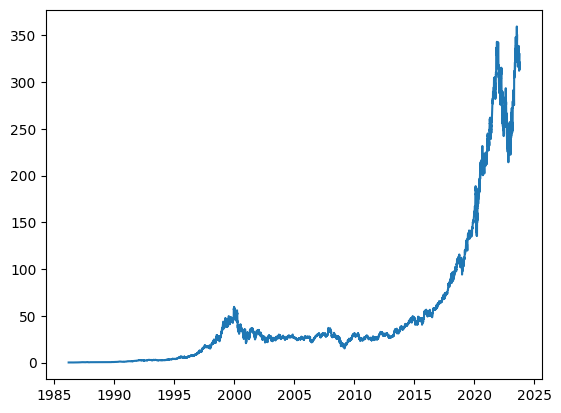

In [27]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

# Windowed Data Preparation

The code defines functions to create a windowed dataset suitable for time series analysis. It splits the data into input features and target values.

In [28]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [29]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

# The dataset is further divided into training, validation, and testing sets.

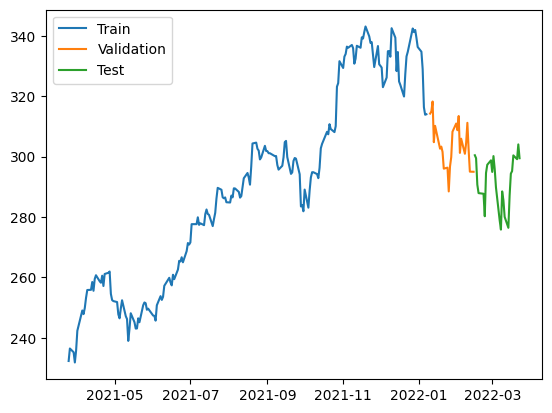

In [30]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

# LSTM Model Building

A deep learning model using LSTM layers is constructed for stock price prediction.

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 69s 506ms/step - loss: 84589.0859 - mean_absolute_error: 289.1003 - val_loss: 92206.6562 - val_mean_absolute_error: 303.5682
Epoch 2/100
7/7 [==============================] - 0s 24ms/step - loss: 84250.3906 - mean_absolute_error: 288.5147 - val_loss: 91854.5391 - val_mean_absolute_error: 302.9877
Epoch 3/100
7/7 [==============================] - 0s 21ms/step - loss: 83892.5469 - mean_absolute_error: 287.8903 - val_loss: 91432.2812 - val_mean_absolute_error: 302.2901
Epoch 4/100
7/7 [==============================] - 0s 22ms/step - loss: 83428.2266 - mean_absolute_error: 287.0846 - val_loss: 90822.0391 - val_mean_absolute_error: 301.2791
Epoch 5/100
7/7 [==============================] - 0s 26ms/step - loss: 82785.6484 - mean_absolute_error: 285.9606 - val_loss: 90066.7109 - val_mean_absolute_error: 300.0228
Epoch 6/100
7/7 [==============================] - 0s 25ms/step - loss: 81956.5938 - mean_absolute_error: 284.5076 - val_loss: 8

7/7 [==============================] - 0s 19ms/step - loss: 20.9081 - mean_absolute_error: 3.7063 - val_loss: 89.4004 - val_mean_absolute_error: 7.8404
Epoch 98/100
7/7 [==============================] - 0s 21ms/step - loss: 29.0715 - mean_absolute_error: 4.3381 - val_loss: 118.5505 - val_mean_absolute_error: 9.3281
Epoch 99/100
7/7 [==============================] - 0s 22ms/step - loss: 28.9981 - mean_absolute_error: 4.3701 - val_loss: 62.2564 - val_mean_absolute_error: 6.4943
Epoch 100/100
7/7 [==============================] - 0s 21ms/step - loss: 27.2059 - mean_absolute_error: 4.2524 - val_loss: 35.1741 - val_mean_absolute_error: 4.7365


# Model Evaluation and Visualization

# The model is evaluated on the training, validation, and testing sets, and the results are visualized

7/7 [==============================] - 3s 6ms/step


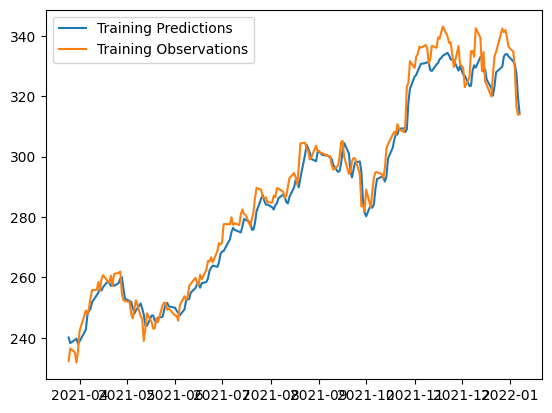

In [32]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 31ms/step


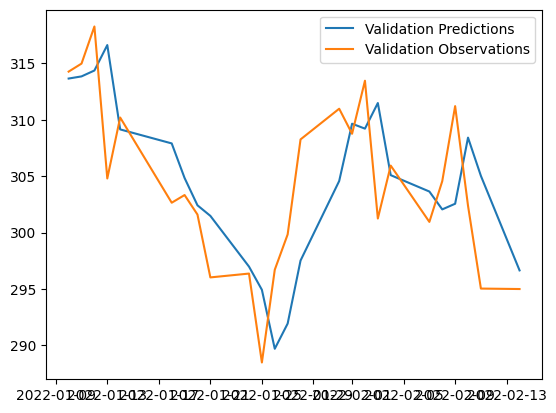

In [33]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 70ms/step


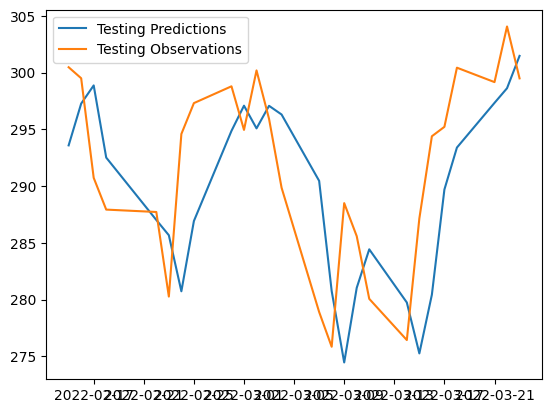

In [34]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

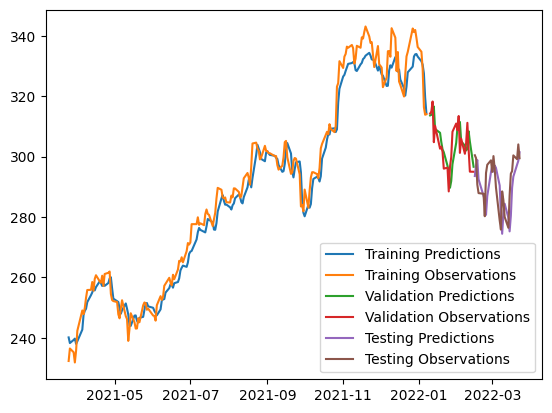

In [35]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

# Recursive predictions are generated to simulate future predictions.

In [36]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 70ms/step


# The predictions and actual observations are plotted for training, validation, testing, and recursive predictions.

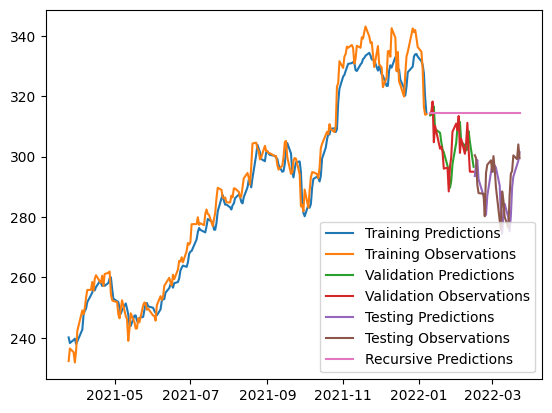

In [37]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])